<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/Regression/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D1%8F%D0%B4%D0%B0_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_Sequence_to_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error, r2_score
import gdown, gc

In [ ]:
# Загрузка датасетов с котировками акций
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [ ]:
# Чтение данных в таблицы
data16_17 = pd.read_csv('16_17.csv', sep=';')
data18_19 = pd.read_csv('18_19.csv', sep=';')
# Создание общего набора данных из двух датасетов
df = pd.concat([data16_17, data18_19]).dropna()
df

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231
...,...,...,...,...,...,...,...
217942,23.08.2019,18:45:00,5183.5,5183.5,5183.5,5183.5,31523
217943,23.08.2019,18:46:00,5183.5,5183.5,5183.5,5183.5,5090
217944,23.08.2019,18:47:00,5183.5,5183.5,5183.5,5183.5,230
217945,23.08.2019,18:48:00,5183.5,5183.5,5183.5,5183.5,5


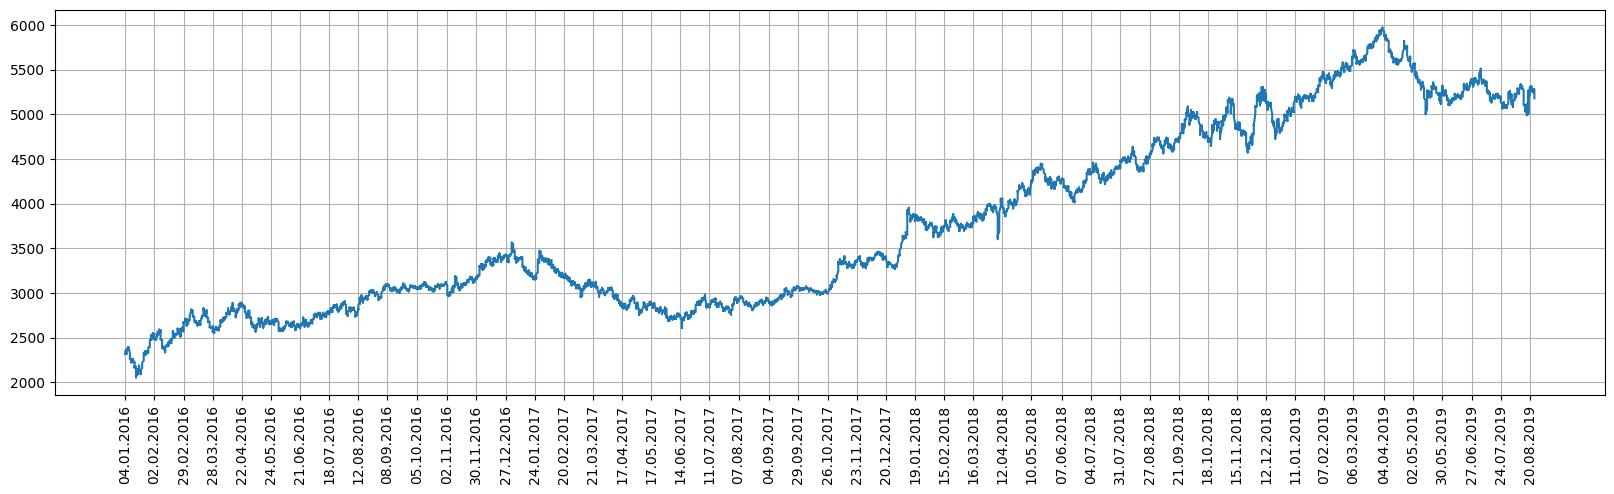

In [ ]:
# Посмотрим на график и удалим ненужные столбцы
N = 50
step = 200
plt.figure(figsize=(20, 5))
plt.plot(df['DATE'][::N],df['CLOSE'][::N])
plt.xticks(df['DATE'][::N][::step], df['DATE'][::N][::step], rotation=90)
plt.grid()
plt.show()
plt.close()
df = df.drop(columns=['DATE', 'TIME'])

(288400, 240, 5)
(288400, 3, 1)

(95651, 240, 5)
(95651, 3, 1)

(96133, 240, 5)
(96133, 3, 1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 5)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 3, 1)]               0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 128),                68608     ['input_1[0][0]']             
                              (None, 128),                                                        
                              (None, 128)]                                                        

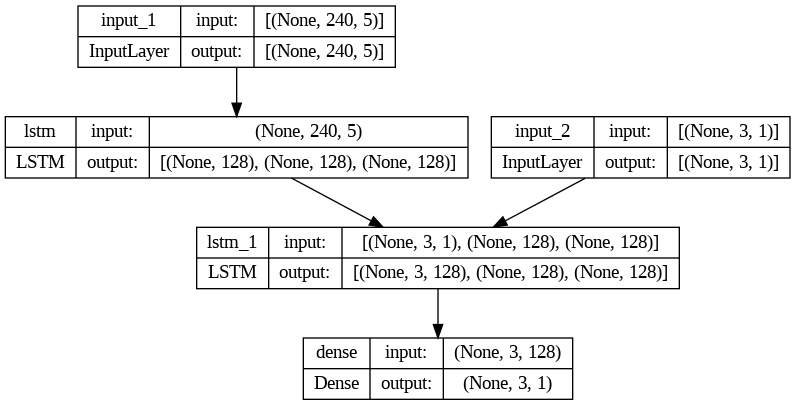

In [ ]:
# параметры
epochs=25                   # число эпох обучения
batch_size=100
look_back = 240             # величина набора данных из истории, по которой делаем прогноз
n_steps = 3                 # глубина прогноза
hidden_dim = 128            # размерность скрытого пространства LSTM
n_features = df.shape[1]    # число признаков, учитываемых для постороения прогноза

# Перевод данных в numpy массив
data = df.values

# Масштабирование данных
def scaler(data,fit_data):
    scal = MaxAbsScaler()#MinMaxScaler()#StandardScaler()#RobustScaler()
    scal.fit(fit_data)
    return scal.transform(data)

# Обратное масштабирование данных
def inverse_scaler(data, fit_data):
    scal = MaxAbsScaler()#MinMaxScaler()#StandardScaler()#RobustScaler()
    scal.fit(fit_data)
    return scal.inverse_transform(data)

# Разделение данных на тренировочные, валидационные и тестовые
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size
hole = int(len(data) * 0.001)   # зазор между наборами данных для защиты от взаимного влияния

train_data_unscal, val_data_unscal, test_data_unscal = data[0:train_size-hole,:], data[train_size:train_size+val_size-hole,:], data[train_size+val_size:len(data),:]

# Нормировка данных
train_data = scaler(train_data_unscal, train_data_unscal)
val_data = scaler(val_data_unscal, train_data_unscal)
test_data = scaler(test_data_unscal, train_data_unscal)

# Функция для создания последовательных наборов данных
def create_dataset(dataset, look_back, n_steps):
    X, Y = [], []
    for i in range(len(dataset) - look_back - n_steps + 1):
        X.append(dataset[i:i+look_back, :])                     # для обучения берем все пять параметров торговых данных
        Y.append(dataset[i+look_back:i+look_back+n_steps, 3])   # предсказывать будем данные CLOSE
    return np.array(X), np.array(Y)

# Создание последовательных наборов данных
X_train, y_train = create_dataset(train_data, look_back, n_steps)
X_val, y_val = create_dataset(val_data, look_back, n_steps)
X_test, y_test = create_dataset(test_data, look_back, n_steps)

# Изменение размерности выходных данных для LSTM
y_train = np.reshape(y_train, (y_train.shape[0], n_steps, 1))
y_val = np.reshape(y_val, (y_val.shape[0], n_steps, 1))
y_test = np.reshape(y_test, (y_test.shape[0], n_steps, 1))

# Создание Seq2Seq модели
encoder_inputs = Input(shape=(look_back, n_features))
encoder_lstm = LSTM(hidden_dim, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(n_steps, 1))
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')
gc.collect()
print(X_train.shape)
print(y_train.shape)
print()
print(X_val.shape)
print(y_val.shape)
print()
print(X_test.shape)
print(y_test.shape)
print()
print(model.summary())
plot_model(model, show_shapes=True)



Epoch 1/25
2884/2884 [==============================] - 53s 17ms/step - loss: 7.8311e-04 - val_loss: 1.8825e-05
Epoch 2/25
2884/2884 [==============================] - 53s 18ms/step - loss: 4.1133e-06 - val_loss: 2.6983e-05
Epoch 3/25
2884/2884 [==============================] - 48s 17ms/step - loss: 6.8547e-06 - val_loss: 1.7567e-05
Epoch 4/25
2884/2884 [==============================] - 46s 16ms/step - loss: 5.0298e-06 - val_loss: 2.1238e-05
Epoch 5/25
2884/2884 [==============================] - 45s 16ms/step - loss: 3.7192e-06 - val_loss: 1.3372e-04
Epoch 6/25
2884/2884 [==============================] - 44s 15ms/step - loss: 2.9210e-06 - val_loss: 8.0078e-06
Epoch 7/25
2884/2884 [==============================] - 45s 15ms/step - loss: 4.5065e-06 - val_loss: 1.1100e-05
Epoch 8/25
2884/2884 [==============================] - 44s 15ms/step - loss: 1.3321e-06 - val_loss: 7.4226e-06
Epoch 9/25
2884/2884 [==============================] - 48s 17ms/step - loss: 1.8091e-06 - val_loss: 3.3

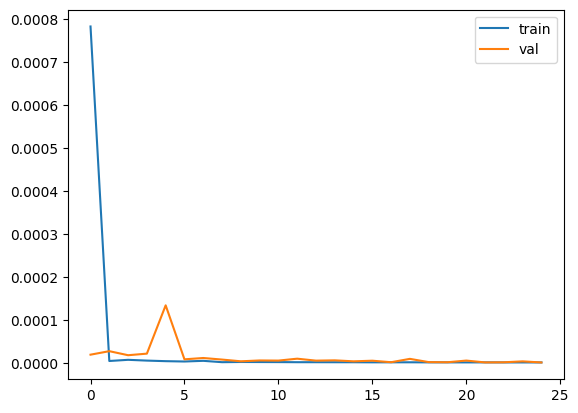

3005/3005 [==============================] - 17s 5ms/step


In [ ]:
# Обучение модели
history = model.fit([X_train, y_train], y_train, epochs=epochs, batch_size=batch_size, validation_data=([X_val, y_val], y_val))

# Визуализация процесса обучения
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

# Предсказание на тестовых данных
y_pred = model.predict([X_test, y_test])

MSE_1:  156.59297321315276
R2_1:  0.9974729640931472

MSE_2:  153.22407021230416
R2_2:  0.9975273301267895

MSE_3:  141.65903169120503
R2_3:  0.9977139621767932



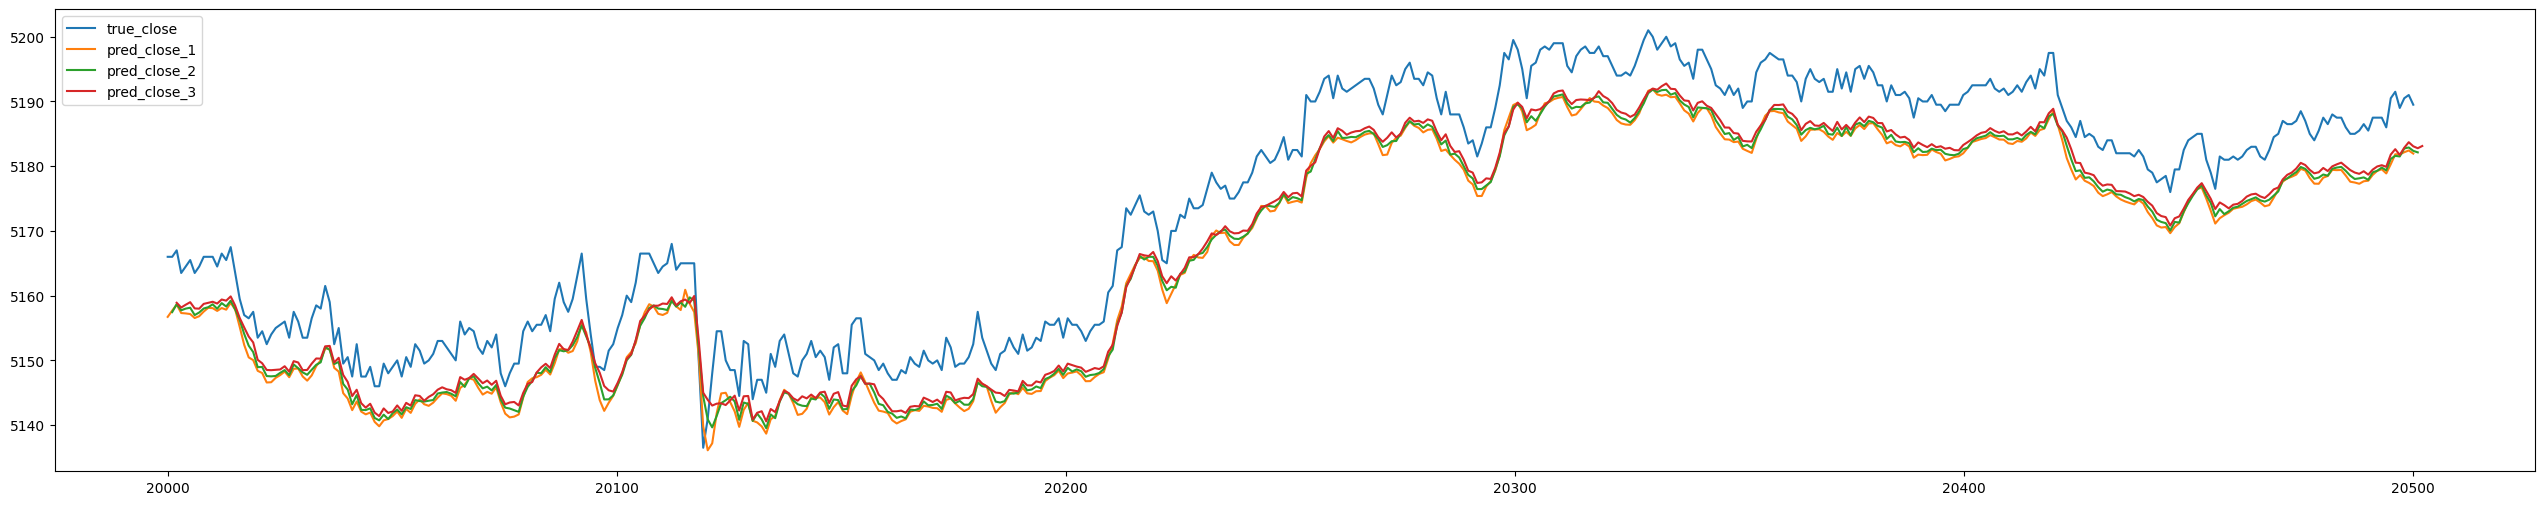

In [ ]:
# Обратное масштабирование данных
y_test_inv = inverse_scaler(y_test[:,0,:], train_data_unscal[-len(y_test):,3].reshape(-1, 1))
plt.figure(figsize=(32, 6))
lower, upper = 20000, 20500
#lower, upper = 0, len(y_test_inv)
x_values = np.linspace(lower, upper, len(y_test_inv[lower:upper]))

# Визуализация реальных данных тестового набора
plt.plot(x_values,y_test_inv[lower:upper], label='true_close')

for i in range(n_steps):
  y_pred_inv = inverse_scaler(y_pred[:,i,:], train_data_unscal[-len(y_test)-i:,3].reshape(-1, 1))

  # Оценка качества модели
  mse = mean_squared_error(y_test_inv, y_pred_inv)
  r2 = r2_score(y_test_inv, y_pred_inv)
  print(f'MSE_{i+1}: ', mse)
  print(f'R2_{i+1}: ', r2)
  print()

  # Визуализация предсказанных данных тестового набора на каждый из n_steps шагов вперед
  plt.plot(x_values+i,y_pred_inv[lower:upper], label=f'pred_close_{i+1}')
  plt.legend()
plt.show()